In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import numpy as np
import copy

from buffer import ReplayBuffer


def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

class GaussianPolicy(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim=256,
        action_scale=1.0,
        action_bias=0.0,
        max_log_std=2,
        min_log_std=-20,
        repr_noise=1e-6,
    ):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

        self.action_scale = action_scale
        self.action_bias = action_bias
        self.max_log_std = max_log_std
        self.min_log_std = min_log_std
        self.repr_noise = repr_noise

        self.apply(weights_init_)

    def forward(self, state):
        h = F.relu(self.fc1(state))
        h = F.relu(self.fc2(h))
        mu = self.mu(h)
        log_std = self.log_std(h)
        log_std = torch.clamp(log_std, min=self.min_log_std, max=self.max_log_std)

        return mu, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)

        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + self.repr_noise)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def act(self, state):
        # print(state.shape, self.fc1)
        mean, _ = self.forward(state)
        return torch.tanh(mean) * self.action_scale + self.action_bias


class Critic(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim=256,
    ):
        super().__init__()
        def make_critic():
            critic = nn.Sequential(
                nn.Linear(state_dim + action_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1),
            )

            return critic
        
        self.critic1 = make_critic()
        self.critic2 = make_critic()
        self.apply(weights_init_)
    
    def forward(self, state, action):
        cat = torch.cat([state, action], dim=1)
        return (
            self.critic1(cat),
            self.critic2(cat)
        )

class SAC(object):
    def __init__(
        self,
        env,
        # essential args for RL
        rollout_model=None,
        discount=0.99,
        tau=5e-3,
        # the following args are for networks
        actor_lr=3e-4,
        critic_lr=3e-4,
        learn_alpha=True,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.env = env
        self.discount = discount
        self.tau = tau

        self.rollout_model = rollout_model
        if rollout_model is not None:
            self.model_based = True
        else:
            self.model_based = False

        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.max_action = float(self.env.action_space.high[0])

        # set networks 
        self.actor = GaussianPolicy(
            state_dim=self.state_dim,
            action_dim=self.action_dim,
            action_scale=self.max_action,
        ).to(self.device)
        
        self.critic = Critic(
            state_dim=self.state_dim,
            action_dim=self.action_dim,
        ).to(self.device)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.learn_alpha = learn_alpha
        if learn_alpha:
            self.entropy_target = -np.prod(
                    self.env.action_space.shape).item()
            self.entropy_target = torch.tensor(self.entropy_target).to(self.device) # convert the numpy.ndarray to torch.tensor
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_opt = torch.optim.Adam(
                [self.log_alpha],
                lr=actor_lr,
            )
            
    def create_empty_replay_buffer(self, buffer_size=int(1e6)):
        return ReplayBuffer(
            state_dim=self.state_dim,
            action_dim=self.action_dim,
            max_size=buffer_size,
        )

    def set_rollout_model(self, rollout_model):
        assert rollout_model is not None, 'Cannot set a none-type rollout model'
        self.rollout_model = rollout_model
        self.model_based = True

    def select_action(self, state, deterministic=False):
        with torch.no_grad():
            state = torch.from_numpy(state.reshape(1, -1)).float().to(self.device)
            if deterministic:
                action = self.actor.act(state)
            else:
                action, _, _ = self.actor.sample(state)
        return action.squeeze(0).data.cpu().numpy()

    def train(self, replay_buffer, batch_size):
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)
        # first train the alpha
        if self.learn_alpha:
            new_action, log_prob, mean = self.actor.sample(state)
            log_prob = log_prob.unsqueeze(-1)
            alpha_loss = -(self.log_alpha * (log_prob + self.entropy_target).detach()).mean()
            alpha = self.log_alpha.exp()
        else:
            alpha_loss = 0
            alpha = 1

        q_new_action = torch.min(
            *self.critic(state, new_action)
        )
        actor_loss = (alpha*log_prob - q_new_action).mean()

        with torch.no_grad():
            next_action, new_log_prob, next_mean = self.actor.sample(next_state)
            new_log_prob = new_log_prob.unsqueeze(-1)
            target_Q = torch.min(
                *self.critic_target(next_state, next_action)
            ) - alpha * new_log_prob
            target_Q = reward + not_done * self.discount * target_Q
        
        Q1, Q2 = self.critic(state, action)
        critic_loss = F.mse_loss(Q1, target_Q) + F.mse_loss(Q2, target_Q)

        # update networks
        if self.learn_alpha:
            self.alpha_opt.zero_grad()
            alpha_loss.backward()
            self.alpha_opt.step()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        self.update_target_network()
    
    def update_target_network(self):
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def learn(self, replay_buffer, step_size, expl_step_size, file_name, batch_size=32, eval_freq=int(1e3)):
        # make aliases
        env = self.env
        state = env.reset()
        evaluations = []
        episode_reward = 0
        episode_timesteps = 0
        episode_num = 0
        expl_step_size = max(batch_size, expl_step_size)

        for step in range(step_size):
            episode_timesteps += 1
            # pick the action
            if step < expl_step_size:
                action = env.action_space.sample()
            else:
                action = self.select_action(np.array(state), deterministic=False)
            
            # perform the action
            next_state, reward, done, _ = env.step(action)
            done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0
            
            # add the transition to the replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)
            
            state = next_state
            episode_reward += reward
            
            if step >= expl_step_size:
                self.train(replay_buffer, batch_size)
            
            if done: 
                # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
                print(f"Total T: {step+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
                # Reset environment
                state, done = env.reset(), False
                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1
            
            if (step + 1) % eval_freq == 0:
                evaluations.append(self.evaluate())
                # np.save(f"./results/{file_name}", evaluations)
                # if args.save_model: policy.save(f"./models/{file_name}")
                
        return evaluations
            

    def evaluate(self, seed=0, eval_episodes=10):
        eval_env = self.env

        eval_env.seed(seed + 100)

        avg_reward = 0.
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            while not done:
                action = self.select_action(np.array(state), deterministic=True)
                # print(state.shape, np.array(state).shape)
                next_state, reward, done, _ = eval_env.step(action)
                # print(state.shape, next_state.shape)
                state = next_state
                avg_reward += reward

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

In [80]:
import gym

env = gym.make('Hopper-v2')

agent = SAC(env)
replay_buffer = agent.create_empty_replay_buffer()
evaluations = agent.learn(
    replay_buffer=replay_buffer,
    step_size=int(1e5),
    expl_step_size=int(1e4),
    batch_size=256,
    file_name='SAC-test-MountainCar',
    eval_freq=int(5e3),
)

Total T: 10 Episode Num: 1 Episode T: 10 Reward: 7.666
Total T: 36 Episode Num: 2 Episode T: 26 Reward: 16.812
Total T: 51 Episode Num: 3 Episode T: 15 Reward: 11.037
Total T: 61 Episode Num: 4 Episode T: 10 Reward: 5.647
Total T: 76 Episode Num: 5 Episode T: 15 Reward: 9.084
Total T: 97 Episode Num: 6 Episode T: 21 Reward: 20.087
Total T: 116 Episode Num: 7 Episode T: 19 Reward: 11.835
Total T: 130 Episode Num: 8 Episode T: 14 Reward: 10.437
Total T: 143 Episode Num: 9 Episode T: 13 Reward: 6.854
Total T: 154 Episode Num: 10 Episode T: 11 Reward: 9.617
Total T: 174 Episode Num: 11 Episode T: 20 Reward: 9.340
Total T: 196 Episode Num: 12 Episode T: 22 Reward: 18.408
Total T: 223 Episode Num: 13 Episode T: 27 Reward: 15.611
Total T: 237 Episode Num: 14 Episode T: 14 Reward: 12.655
Total T: 252 Episode Num: 15 Episode T: 15 Reward: 11.874
Total T: 265 Episode Num: 16 Episode T: 13 Reward: 11.405
Total T: 287 Episode Num: 17 Episode T: 22 Reward: 23.749
Total T: 323 Episode Num: 18 Episod

/home/yiranwang/anaconda3/envs/offline/lib/python3.7/site-packages/ipykernel_launcher.py:206: UserWarning: Using a target size (torch.Size([256, 256, 1])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Total T: 10059 Episode Num: 455 Episode T: 46 Reward: 74.139
Total T: 10071 Episode Num: 456 Episode T: 12 Reward: 8.669
Total T: 10090 Episode Num: 457 Episode T: 19 Reward: 11.495
Total T: 10107 Episode Num: 458 Episode T: 17 Reward: 14.917
Total T: 10126 Episode Num: 459 Episode T: 19 Reward: 15.491
Total T: 10140 Episode Num: 460 Episode T: 14 Reward: 11.481
Total T: 10163 Episode Num: 461 Episode T: 23 Reward: 15.433
Total T: 10183 Episode Num: 462 Episode T: 20 Reward: 21.859
Total T: 10247 Episode Num: 463 Episode T: 64 Reward: 96.852
Total T: 10266 Episode Num: 464 Episode T: 19 Reward: 13.231
Total T: 10288 Episode Num: 465 Episode T: 22 Reward: 23.796
Total T: 10306 Episode Num: 466 Episode T: 18 Reward: 5.201
Total T: 10341 Episode Num: 467 Episode T: 35 Reward: 38.263
Total T: 10361 Episode Num: 468 Episode T: 20 Reward: 16.432
Total T: 10402 Episode Num: 469 Episode T: 41 Reward: 56.269
Total T: 10448 Episode Num: 470 Episode T: 46 Reward: 64.494
Total T: 10459 Episode Num

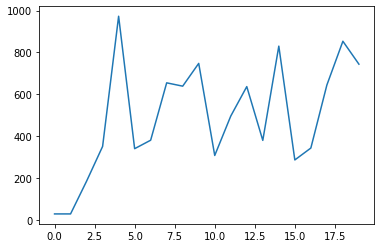

In [77]:
import matplotlib.pyplot as plt

plt.plot(evaluations)

In [51]:
env = agent.env
action = env.action_space.sample()
state = env.reset()
next_state, reward, done, _ = env.step(action)
print(state.shape, next_state.shape)

(2,) (2,)


In [58]:
action = agent.select_action(state, deterministic=True)
action = action.repeat(10, 1)

In [ ]:
env.step

In [59]:
next_state, reward, done, _ = env.step(action)
print(state.shape, next_state.shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()